In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as st

### Question 1)
Look up and/or derive this theoretical result, at least for n=2. Describe how it is derived. Can you also give a non-mathematical explanation?

#### Answer
In queuing theory, the average waiting time in a system depends significantly on the number of servers and the arrival and service rates. For a single-server system, known as an M/M/1 queue, the average waiting time in the queue, denoted as $W_q(1)$, is given by:

$$
W_q(1) = \frac{\rho}{\mu (1 - \rho)} \tag{1}
$$

where $\rho = \frac{\lambda}{\mu}$ is the traffic intensity, $\lambda$ is the arrival rate, and $\mu$ is the service rate.

The average time a customer spends in the system, $W(1)$, including both waiting and service time, is:

\begin{equation}
W(1) = W_q(1) + \frac{1}{\mu} = \frac{1}{\mu - \lambda} \tag{2}
\end{equation}

As the system load $\rho$ increases (i.e., as the arrival rate approaches the service rate), the waiting time increases significantly due to higher congestion.

For a multi-server system, such as an M/M/n queue with $n$ servers, the average waiting time is generally shorter. Considering an M/M/2 queue as an example, the probability that there are zero customers in the system, $P_0$, can be calculated without using summations by expanding the terms of the following equation:

\begin{equation}
P_0 = \left( \sum_{k=0}^{n-1} \frac{a^k}{k!} + \frac{a^n}{n!(1 - \rho)} \right)^{-1} \tag{3}
\end{equation}

With $a = \lambda/\mu $, which gives:

\begin{equation} P_0 = \left( \frac{(\lambda/\mu)^0}{0!} + \frac{(\lambda/\mu)^1}{1!} + \frac{(\lambda/\mu)^2}{2!(1 - \rho)} \right)^{-1} \tag{4}\end{equation}

Simplifying, this becomes:

\begin{equation}
P_0 = \left( 1 + \frac{\lambda}{\mu} + \frac{(\lambda/\mu)^2}{2(1 - \rho)} \right)^{-1} \tag{5}
\end{equation}

The probability that an arriving customer has to wait, $P_w$, is calculated as:

\begin{equation}
P_w = \frac{(\lambda/\mu)^2}{2(1 - \rho)} P_0 \tag{6}
\end{equation}

The average waiting time in the queue for the M/M/2 system is then:

\begin{equation}
W_q(2) = \frac{P_w}{2\mu(1 - \rho)} \tag{7}
\end{equation}

The average time a customer spends in the system is:

\begin{equation}
W(2) = W_q(2) + \frac{1}{\mu} \tag{8}
\end{equation}

Due to the presence of multiple servers in the M/M/2 queue, the probability that a customer has to wait ($P_w$) is lower than in the M/M/1 queue. This results in a shorter average waiting time in the queue ($W_q(2) < W_q(1)$), and therefore, the total average time in the system is also shorter:

\begin{equation}
W(2) < W(1) \tag{9}
\end{equation}

This demonstrates that multi-server systems can handle the same load more efficiently than single-server systems, leading to reduced waiting times and improved performance.

The shorter average waiting time in an M/M/2 queue compared to an M/M/1 queue with the same system load $\rho$ can be explained intuitively. In the M/M/2 system, two servers share the workload, reducing the likelihood that both servers are busy at the same time. This means that arriving customers are less likely to encounter a busy system and have to wait. The system benefits from resource pooling, where the variability in arrival and service times is better absorbed due to the availability of multiple servers. This leads to shorter queues and reduced waiting times compared to a single-server system.

By comparing these two systems, it becomes clear that the average waiting time and overall system performance are heavily influenced by the number of servers and the scheduling algorithms employed. Multi-server systems with efficient scheduling can significantly improve performance, especially under high load conditions.

### Question 2)
Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on ρ?

#### Answer:
To answer this question Simpy is used to implement the queueing system and after implementing it and taking the average of the waiting time over 100 simulations we compared this with the theoretical values obtained by equation [7]

In [2]:
# Used as a guide: https://simpy.readthedocs.io/en/latest/examples/bank_renege.html
def source(env, time_total, Lambda, counter, waiting_times, mu):
    """Generates customers and puts them into the queue.

    Parameters:
    env : simpy.Environment
        The simulation environment.
    time_total : Total simulation time.
    Lambda : Arrival rate (customers per unit time).
    counter : simpy.Resource
        The service counter representing the servers.
    waiting_times : A list to store the waiting times of customers.
    mu : Service rate (services completed per unit time per server). """

    for i in range(time_total):    
        c = customer(env, f'Customer{i:02d}', counter, waiting_times, mu)
        env.process(c)
        t = random.expovariate(Lambda)

        yield env.timeout(t)
        
def customer(env, name, counter, timer, mu):
    """Simulates the behavior of a customer in an M/M/n queue with FIFO scheduling.

    Parameters:
    env : simpy.Environment
        The simulation environment.
    name : The name or identifier of the customer.
    counter : simpy.Resource
        The resource representing the service counter or servers.
    timer : A list to record the waiting times of customers.
    mu : Service rate."""

    arrive = env.now
    with counter.request() as req:

        yield req
        wait = env.now - arrive
        timer.append(wait)

        time_in = random.expovariate(mu)
        yield env.timeout(time_in)

def run_simulation(num_servers, N, Lambda, mu, time_total):
    """Runs a simulation of an M/M/n queueing system and calculates performance metrics.

    Parameters:
    num_servers : Number of servers in the system.
    N : Number of simulation runs for averaging results.
    Lambda : Arrival rate.
    mu : Service rate.
    time_total : Total simulation time for each run.
    
    Returns: average waiting time and corresponding error."""
    
    timer = []
    for test in range(N):
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=num_servers)
        env.process(source(env, time_total, Lambda, counter, timer, mu))
        env.run()
    average = np.mean(timer)
    ci = st.t.interval(0.95, len(timer) - 1, loc=average, scale=st.sem(timer))
    error = (ci[1] - ci[0]) / 2
    return average, error

def theoretical(Lambda, mu, n):
    """ This function computes the theoretical average waiting time (Wq) based on equation [7] for an M/M/n queue.
    
    Parameters:
    Lambda : Arrival rate 
    mu : Service rate
    n : Number of servers.

    Returns: Average waiting time in the queue (Wq)
    """

    rho = Lambda / (n * mu)
    a = Lambda / mu
    P0 = (sum((a) ** k / np.math.factorial(k) for k in range(n)) + ((a) ** n / (np.math.factorial(n) * (1 - rho)))) ** (-1)
    Pw = ((a **n ) / (np.math.factorial(n) * (1 - rho))) * P0

    Wqn = Pw / (n * mu * (1 - rho))
    return Wqn

/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_9472/892368540.py:80: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P0 = (sum((a) ** k / np.math.factorial(k) for k in range(n)) + ((a) ** n / (np.math.factorial(n) * (1 - rho)))) ** (-1)
/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_9472/892368540.py:81: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  Pw = ((a **n ) / (np.math.factorial(n) * (1 - rho))) * P0


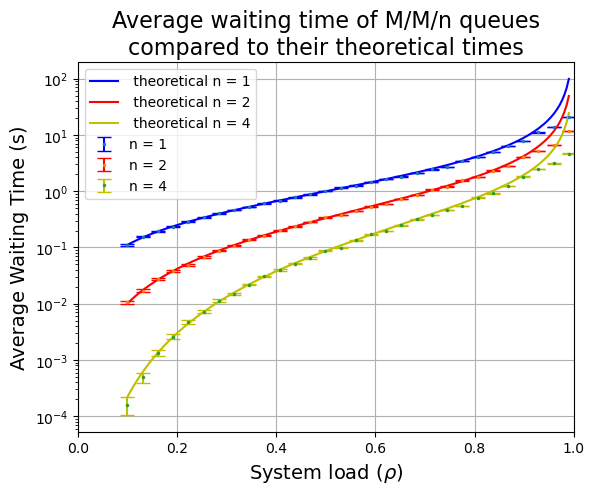

In [3]:
# Parameter for answering question 2 and 3
load = np.linspace(0.1, 0.99, 30)
mu = 1
time_total = 1000
N = 100

# Code to call run simulations for n = 1 , n = 2 and n = 4
for servers in [1,2,4]:
    collected_times = []
    errors = []
    for value in load:
        Lambda = value * servers * mu
        result, error = run_simulation(servers, N, Lambda, mu, time_total)
        collected_times.append(result)
        errors.append(error)

    if servers == 1:
        tag = 'b'
    elif servers == 2:
        tag = 'r'
    elif servers == 4:
        tag = 'y'
    plt.errorbar(load, collected_times, yerr=errors, 
                        label = f'n = {servers}', ecolor =tag, fmt= '.',
                        capsize=5,markersize=3)
    #plt.plot(load, collected_times,'.', color =tag, label = f'n = {servers}')

# Code to plot the theoretical values in the Figure 
load = np.linspace(0.1, 0.99, 200)
for servers in [1,2,4]:
    theoretical_times = []
    for value in load:
        Lambda = value * servers * mu
        result = theoretical(Lambda, mu, servers)
        theoretical_times.append(result)

    if servers == 1:
        tag = 'b'
    elif servers == 2:
        tag = 'r'
    elif servers == 4:
        tag = 'y'

    plt.plot(load, theoretical_times, color = tag, label = f' theoretical n = {servers}')
plt.legend()
plt.grid()
plt.yscale('log')
plt.xlabel(r'System load ($\rho$)', fontsize = 14)
plt.ylabel('Average Waiting Time (s)', fontsize = 14)
plt.title('Average waiting time of M/M/n queues\ncompared to their theoretical times', fontsize = 16)
plt.xlim(0,1)
plt.savefig('MMn_vs_theoretical.png', dpi = 400)
plt.show()

### Question 3)
Also compare the result to that for an M/M/1 queue with the shortest job first scheduling, where you always give priority to the smallest jobs.

#### Answer 
We implement the shortest job first schedule by adapting the function that generates customers by letting it specify if it uses the function customer (for fifo scheduling) or the function customer_sjf (for shortest job first). In the latter, priority is given to customers with a smaller service time. The run simulation function is also adapted to implement and run the SJF schedule queue.

We see that as expected the SJF has a lower waiting time than the FIFO scheduling and is thus more efficient.

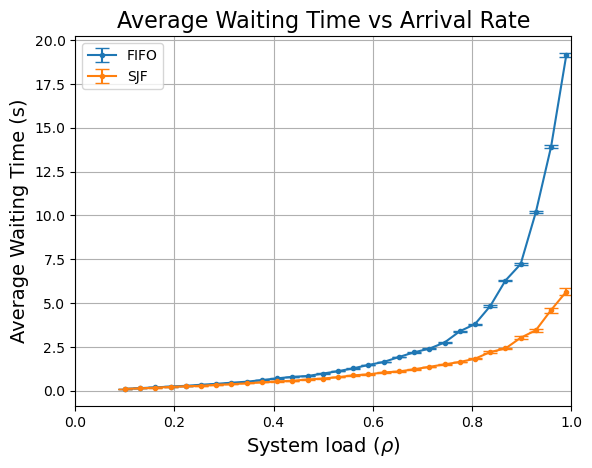

In [4]:
def source(env, time_total, Lambda, counter, waiting_times, mu, sjf=False):
    """Generates customers and puts them into the queue for either a sjf or fifo algotihm

    Parameters:
    env : simpy.Environment
        The simulation environment.
    time_total : Total simulation time.
    Lambda : Arrival rate (customers per unit time).
    counter : simpy.Resource
        The service counter representing the servers.
    waiting_times : A list to store the waiting times of customers.
    mu : Service rate (services completed per unit time per server).
    sjf: Allows for choice in applying SJF or not."""
    
    for i in range(time_total):
        if sjf:
            service_time = random.expovariate(mu)
            c = customer_sjf(env, f'Customer{i:02d}', counter, waiting_times, service_time)
        else:
            c = customer(env, f'Customer{i:02d}', counter, waiting_times, mu)
        env.process(c)
        t = random.expovariate(Lambda)
        yield env.timeout(t)



def customer_sjf(env, name, counter, waiting_times, service_time):
    """Simulates the behavior of a customer in an M/M/n queue with SJF scheduling.

    Parameters:
    env : simpy.Environment
        The simulation environment.
    name : The name or identifier of the customer.
    counter : simpy.Resource
        The resource representing the service counter or servers.
    timer : A list to record the waiting times of customers.
    mu : Service rate."""
    
    arrive = env.now
    with counter.request(priority=service_time) as req: 
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        yield env.timeout(service_time)

def run_simulation(num_servers, N, Lambda, mu, time_total, sjf=False):
    """Runs a simulation of an M/M/n queueing system and calculates performance metrics, where SJF or FIFO needs to be specified

    Parameters:
    num_servers : Number of servers in the system.
    N : Number of simulation runs for averaging results.
    Lambda : Arrival rate.
    mu : Service rate.
    time_total : Total simulation time for each run.
    sjf: Allows for choice in applying SJF or not.
    
    Returns: average waiting time and corresponding error."""
    timer = []
    for _ in range(N):
        env = simpy.Environment()
        if sjf:
            counter = simpy.PriorityResource(env, capacity=num_servers)
        else:
            counter = simpy.Resource(env, capacity=num_servers)
        
        env.process(source(env, time_total, Lambda, counter, timer, mu, sjf))
        env.run()
    average = np.mean(timer)
    ci = st.t.interval(0.95, len(timer)-1, loc=average, scale=st.sem(timer))
    error = (ci[1] - ci[0]) / 2
    return average, error

# Lists for saving the values 
collected_times_fifo = []
collected_times_sjf = []
errors_fifo = []
errors_sjf = []

Lambda_values = np.linspace(0.1, 0.99, 30)
for Lambda in Lambda_values:
    # FIFO scheduling
    avg_wait_fifo, fifo_error = run_simulation(1, N, Lambda, mu, time_total, sjf=False)
    collected_times_fifo.append(avg_wait_fifo)
    errors_fifo.append(fifo_error)

    # SJF scheduling
    avg_wait_sjf, sjf_error = run_simulation(1, N, Lambda, mu, time_total, sjf=True)
    collected_times_sjf.append(avg_wait_sjf)
    errors_sjf.append(sjf_error)
    
# Plotting the average waiting time for FIFO and SJF
plt.errorbar(Lambda_values, collected_times_fifo, yerr=errors_fifo, 
            label='FIFO', fmt= 'o-',
            capsize=5,markersize=3)
plt.errorbar(Lambda_values, collected_times_sjf, yerr=errors_sjf, 
            label='SJF', fmt= 'o-',
            capsize=5,markersize=3)
plt.xlabel(r'System load ($\rho$)', fontsize = 14)
plt.ylabel('Average Waiting Time (s)', fontsize = 14)
plt.title('Average Waiting Time vs Arrival Rate', fontsize = 16)
plt.legend()
plt.grid(True)
plt.xlim(0,1)
plt.savefig('Fifo_vs_Sjf.png', dpi = 400)
plt.show()

### Question 4
Now experiment with different service rate distributions. On the one hand try the M/D/1 and M/D/n queues, on the other hand try a long-tail distribution. For the latter you may e.g. use a distribution where 75% of the jobs have an exponential distribution with an average service time of 1.0 and the remaining 25% an exponential distribution with an average service time of 5.0 (an example of a hyperexponential distribution).

#### Answer
We implement the M/D/1 and M/D/n queues and a long-tail distributionby adapting the function that generates customers by letting the service time be calculated by determinstic function and hyperexponential function.  The run simulation function is also adapted to implement and run the the M/D/1 and M/D/n queues and thw long-tail distributions.

As expected, the M/D/n system exhibits lower waiting times compared to the systems with long-tail distributions, making it more efficient. This is because the deterministic system has less variability, resulting in better flow

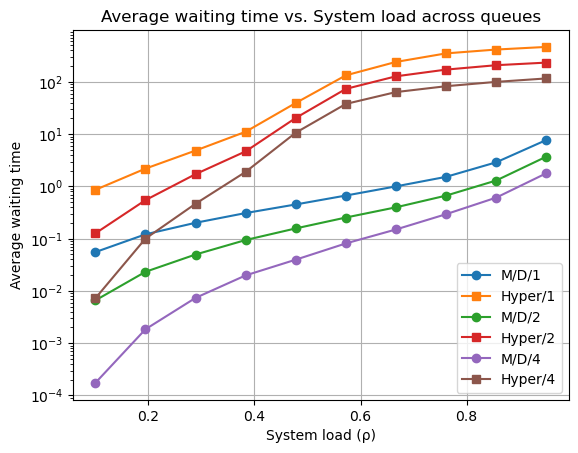

In [5]:
def deterministic_service_time(mu):
    """Calculates a deterministic service time based on the service rate.
    
    Parameters:
    mu : Service rate.

    Returns: Deterministic service time calculated as 1 / mu.
    """
    return 1 / mu

def hyperexponential_service_time():
    """Generates a service time following a hyperexponential distribution.

    Returns: A service time sampled from a hyperexponential distribution.
    
    The distribution is defined as:
    - With probability 0.75, the service time is drawn from an exponential distribution with rate 1.
    - With probability 0.25, it is drawn from an exponential distribution with rate 1/5.
    """
    if random.random() < 0.75:
        return random.expovariate(1)
    else:
        return random.expovariate(1 / 5)

def source(env, time_total, Lambda, counter, waiting_times, service_time_fn):
    """Generates customers and puts them into the queue.

    Parameters:
    env : simpy.Environment
        The simulation environment.
    time_total : Total simulation time.
    Lambda : Arrival rate (customers per unit time).
    counter : simpy.Resource
        The service counter representing the servers.
    waiting_times : A list to store the waiting times of customers.
    mu : Service rate based on hyperexponential or deterministic service time. """
    for i in range(time_total):
        env.process(customer(env, f'Customer{i:02d}', counter, waiting_times, service_time_fn))
        yield env.timeout(random.expovariate(Lambda))
        
def customer(env, name, counter, waiting_times, service_time_fn):
    """Simulates the behavior of a customer.

    Parameters:
    env : simpy.Environment
        The simulation environment.
    name : The name or identifier of the customer.
    counter : simpy.Resource
        The resource representing the service counter or servers.
    waiting_times : A list to record the waiting times of customers.
    service_time_fn : Service time depending on hyperexponential or deterministic service time."""
    
    arrive = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        yield env.timeout(service_time_fn())

def run_simulation(num_servers, rho_values, time_total, N, service_time_fn):
    """Runs a simulation system and calculates performance metrics

    Parameters:
    num_servers : Number of servers in the system.
    N : Number of simulation runs for averaging results.
    Lambda : Arrival rate.
    mu : Service rate.
    time_total : Total simulation time for each run.
    service_time_fn : Service time depending on hyperexponential or deterministic service time.
    
    Returns: average waiting time and corresponding error."""
    results = []
    for rho in rho_values:
        waiting_times = []
        Lambda = rho * num_servers  # Arrival rate
        for _ in range(N):
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=num_servers)
            env.process(source(env, time_total, Lambda, counter, waiting_times, service_time_fn))
            env.run()
        avg_wait = np.mean(waiting_times)
        results.append(avg_wait)
    return results

# Parameters
num_servers_list = [1, 2, 4]  
rho_values = np.linspace(0.1, 0.95, 10)

# here the results are stored for M/D/n and hyper exponential queues
results_md = {}
results_hyper = {}

for n in num_servers_list:
    results_md[n] = run_simulation(n, rho_values, time_total, N, lambda: deterministic_service_time(1))
    results_hyper[n] = run_simulation(n, rho_values, time_total, N, hyperexponential_service_time)

# And the results are plotted
for n in num_servers_list:
    plt.plot(rho_values, results_md[n], label=f'M/D/{n}', marker='o')
    plt.plot(rho_values, results_hyper[n], label=f'Hyper/{n}', marker='s')

plt.xlabel('System load (ρ)')
plt.ylabel('Average waiting time')
plt.title('Average waiting time vs. System load across queues')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

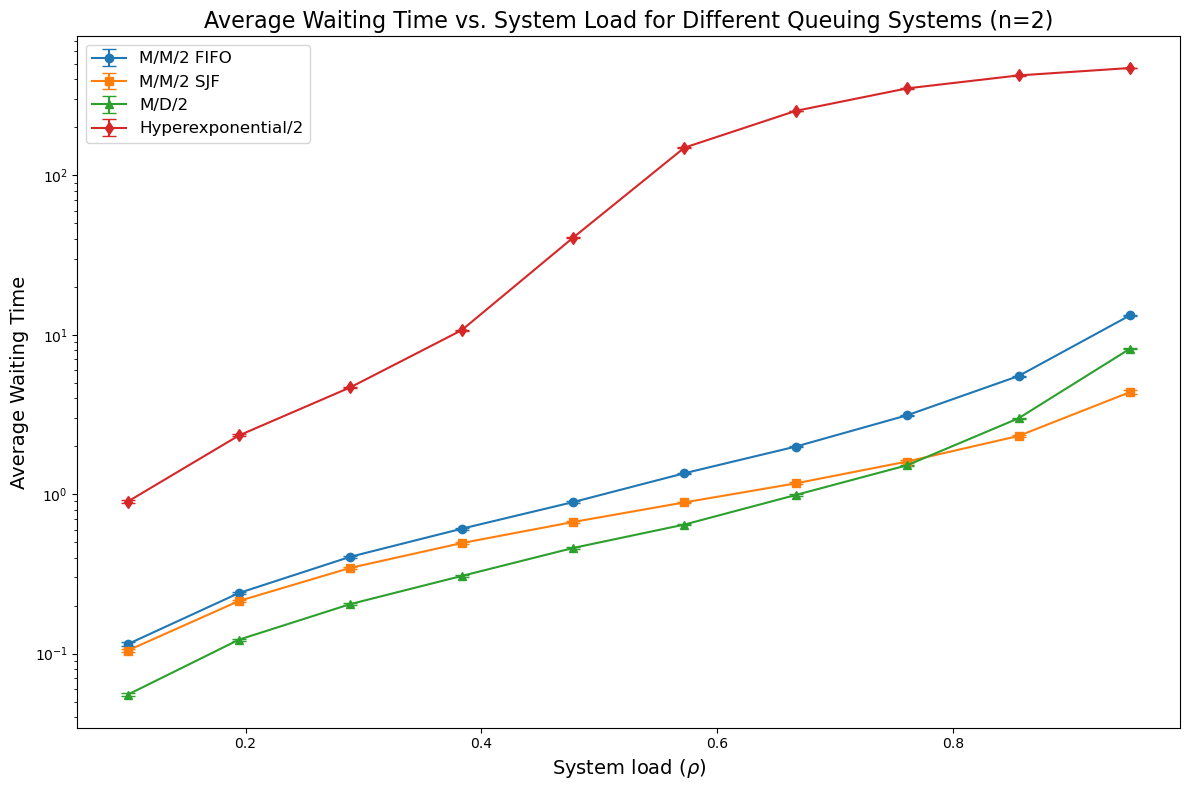

In [10]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Parameters
n = 1        # Number of servers
mu = 1           # Service rate
time_total = 1000  # Total simulation time
N = 100          # Number of simulation runs for averaging
rho_values = np.linspace(0.1, 0.95, 10)  # System load values

# Lists to store results
avg_wait_mm_fifo = []
avg_wait_mm_sjf = []
avg_wait_md = []
avg_wait_hyper = []

errors_mm_fifo = []
errors_mm_sjf = []
errors_md = []
errors_hyper = []

# M/M/2 FIFO Queue
def source_mm_fifo(env, time_total, Lambda, counter, waiting_times, mu):
    for i in range(time_total):    
        c = customer_mm_fifo(env, f'Customer{i:02d}', counter, waiting_times, mu)
        env.process(c)
        t = random.expovariate(Lambda)
        yield env.timeout(t)

def customer_mm_fifo(env, name, counter, waiting_times, mu):
    arrive = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        service_time = random.expovariate(mu)
        yield env.timeout(service_time)

def run_simulation_mm_fifo(num_servers, N, Lambda, mu, time_total):
    waiting_times = []
    for _ in range(N):
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=num_servers)
        env.process(source_mm_fifo(env, time_total, Lambda, counter, waiting_times, mu))
        env.run()
    average = np.mean(waiting_times)
    ci = st.t.interval(0.95, len(waiting_times) - 1, loc=average, scale=st.sem(waiting_times))
    error = (ci[1] - ci[0]) / 2
    return average, error

# M/M/2 SJF Queue
def source_mm_sjf(env, time_total, Lambda, counter, waiting_times, mu):
    for i in range(time_total):
        service_time = random.expovariate(mu)
        c = customer_mm_sjf(env, f'Customer{i:02d}', counter, waiting_times, service_time)
        env.process(c)
        t = random.expovariate(Lambda)
        yield env.timeout(t)

def customer_mm_sjf(env, name, counter, waiting_times, service_time):
    arrive = env.now
    with counter.request(priority=service_time) as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        yield env.timeout(service_time)

def run_simulation_mm_sjf(num_servers, N, Lambda, mu, time_total):
    waiting_times = []
    for _ in range(N):
        env = simpy.Environment()
        counter = simpy.PriorityResource(env, capacity=num_servers)
        env.process(source_mm_sjf(env, time_total, Lambda, counter, waiting_times, mu))
        env.run()
    average = np.mean(waiting_times)
    ci = st.t.interval(0.95, len(waiting_times)-1, loc=average, scale=st.sem(waiting_times))
    error = (ci[1] - ci[0]) / 2
    return average, error

# M/D/2 Queue
def deterministic_service_time(mu):
    return 1 / mu

def source_md(env, time_total, Lambda, counter, waiting_times, mu):
    for i in range(time_total):
        env.process(customer_md(env, f'Customer{i:02d}', counter, waiting_times, mu))
        t = random.expovariate(Lambda)
        yield env.timeout(t)

def customer_md(env, name, counter, waiting_times, mu):
    arrive = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        service_time = deterministic_service_time(mu)
        yield env.timeout(service_time)

def run_simulation_md(num_servers, N, Lambda, mu, time_total):
    waiting_times = []
    for _ in range(N):
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=num_servers)
        env.process(source_md(env, time_total, Lambda, counter, waiting_times, mu))
        env.run()
    average = np.mean(waiting_times)
    ci = st.t.interval(0.95, len(waiting_times) - 1, loc=average, scale=st.sem(waiting_times))
    error = (ci[1] - ci[0]) / 2
    return average, error

# Hyperexponential/2 Queue
def hyperexponential_service_time():
    if random.random() < 0.75:
        return random.expovariate(1)
    else:
        return random.expovariate(1 / 5)

def source_hyper(env, time_total, Lambda, counter, waiting_times):
    for i in range(time_total):
        env.process(customer_hyper(env, f'Customer{i:02d}', counter, waiting_times))
        t = random.expovariate(Lambda)
        yield env.timeout(t)

def customer_hyper(env, name, counter, waiting_times):
    arrive = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        service_time = hyperexponential_service_time()
        yield env.timeout(service_time)

def run_simulation_hyper(num_servers, N, Lambda, time_total):
    waiting_times = []
    for _ in range(N):
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=num_servers)
        env.process(source_hyper(env, time_total, Lambda, counter, waiting_times))
        env.run()
    average = np.mean(waiting_times)
    ci = st.t.interval(0.95, len(waiting_times) - 1, loc=average, scale=st.sem(waiting_times))
    error = (ci[1] - ci[0]) / 2
    return average, error

### Simulation and Data Collection ###

for rho in rho_values:
    Lambda = rho * n * mu  # Arrival rate
    
    # M/M/2 FIFO
    avg_wait, error = run_simulation_mm_fifo(n, N, Lambda, mu, time_total)
    avg_wait_mm_fifo.append(avg_wait)
    errors_mm_fifo.append(error)
    
    # M/M/2 SJF
    avg_wait, error = run_simulation_mm_sjf(n, N, Lambda, mu, time_total)
    avg_wait_mm_sjf.append(avg_wait)
    errors_mm_sjf.append(error)
    
    # M/D/2
    avg_wait, error = run_simulation_md(n, N, Lambda, mu, time_total)
    avg_wait_md.append(avg_wait)
    errors_md.append(error)
    
    # Hyperexponential/2
    avg_wait, error = run_simulation_hyper(n, N, Lambda, time_total)
    avg_wait_hyper.append(avg_wait)
    errors_hyper.append(error)

plt.figure(figsize=(12, 8))

# Plot M/M/2 FIFO
plt.errorbar(rho_values, avg_wait_mm_fifo, yerr=errors_mm_fifo, label='M/M/2 FIFO', fmt='o-', capsize=5)

# Plot M/M/2 SJF
plt.errorbar(rho_values, avg_wait_mm_sjf, yerr=errors_mm_sjf, label='M/M/2 SJF', fmt='s-', capsize=5)

# Plot M/D/2
plt.errorbar(rho_values, avg_wait_md, yerr=errors_md, label='M/D/2', fmt='^-', capsize=5)

# Plot Hyperexponential/2
plt.errorbar(rho_values, avg_wait_hyper, yerr=errors_hyper, label='Hyperexponential/2', fmt='d-', capsize=5)

# Labels and Title
plt.xlabel(r'System load ($\rho$)', fontsize=14)
plt.ylabel('Average Waiting Time', fontsize=14)
plt.title('Average Waiting Time vs. System Load for Different Queuing Systems (n=2)', fontsize=16)

# Log scale for y-axis to handle wide range of waiting times
plt.yscale('log')

plt.legend(fontsize=12)
plt.tight_layout()

# Show Plot
plt.show()